### PROG8245-Machine Learning Programming

**Lab4 - Tidying, Cleaning, Imputation, and Outlier Detection**

Name:Haysam Elamin 

ID: 8953681

**The goal of this project is to:**

This lab focuses on data tidying and cleaning as essential steps in the data engineering process.
Reshape messy datasets using melt() and pivot_table() to make them analysis-ready.
The lab also explores techniques to handle missing values and detect outliers using Z-score and IQR methods.

**Approach**

 Tidying: Reshaped messy data using melt() and pivot_table() for better structure. Cleaning: Handled missing values via dropping or imputation (mean, median, mode). Outlier Detection: Identified outliers using Z-score and IQR methods. Removal: Removed data points outside defined Z-score or IQR thresholds.

**References:**

Machine Learning Week 5 slides
Some code has been modified using Copilo



# **Tidying**

Part of the data engineering process is data cleaning and tidying. What is done in those two processes, is trying to make the data more readable, and complete. This makes much easier to analyze, visualize, and train the data.


## **Data Tidying**

Making the data more organized, and readable is the result of applying data tidying. 

In this section two main pandas functions are used in data tidying those are `melt` and `pivot_table`.

Let's start by taking a look at the below dataframe, which represents the income ranges based on religion. This is part of the PEW research, which is famous in the US for conducting pollings and surveys on citizens.

When the following are satisfied:


1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We can then say that our dataset is *tidy*.

First we need to import pandas to read csv datasets.

In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_diabetes
from scipy.stats import zscore

### **PEW Research Dataset**

1. Start by Importing the dataset into a pandas dataframe.

In [2]:
# loding the CSV file into a pandas dataframe #
pew_path = 'CSVs/pew-raw.csv' # setting the path to the CSV file
pew_df = pd.read_csv(pew_path)
#printing the first 5 rows of the dataframe
print(pew_df.head() ,'\n') 

            religion   <$10k   $10-20k  $20-30k  $30-40k   $40-50k  $50-75k
0           Agnostic      27        34       60       81        76      137
1            Atheist      12        27       37       52        35       70
2           Buddhist      27        21       30       34        33       58
3           Catholic     418       617      732      670       638     1116
4  Dont know/refused      15        14       15       11        10       35 



In [3]:
print('#'*20, 'Columns Name', '#' * 20) # viewing the columns names
print(pew_df.columns)
print('#'*20, 'Data shape', '#' * 20) # viewing the columns names
print(pew_df.shape)

#################### Columns Name ####################
Index(['religion', ' <$10k', ' $10-20k', '$20-30k', '$30-40k', ' $40-50k',
       '$50-75k'],
      dtype='object')
#################### Data shape ####################
(10, 7)


2. Observe the dataset using the `loc`, `iloc`, `head`, or `tail` approaches

In [4]:
print(pew_df.loc[0,' $10-20k'])  # Display row with index '$20-30k'
print(pew_df.iloc[2:5]) # Display rows 2 to 4

34
            religion   <$10k   $10-20k  $20-30k  $30-40k   $40-50k  $50-75k
2           Buddhist      27        21       30       34        33       58
3           Catholic     418       617      732      670       638     1116
4  Dont know/refused      15        14       15       11        10       35


In [5]:
print('#'*20, 'tail', '#' * 20)
print(pew_df.tail())  # Display last 5 rows

#################### tail ####################
                   religion   <$10k   $10-20k  $20-30k  $30-40k   $40-50k  \
5         Evangelical Prot      575       869     1064      982       881   
6                    Hindu        1         9        7        9        11   
7  Historically Black Prot      228       244      236      238       197   
8         Jehovahs Witness       20        27       24       24        21   
9                   Jewish       19        19       25       25        30   

   $50-75k  
5     1486  
6       34  
7      223  
8       30  
9       95  


***What does not seem right in the above dataframe?***
- Some column names contain leading spaces ' $10-20k'
- The data is understandable to humans but not suitable for data processing.
- Each variable must have its own column
- Each observation must have its own row
- Each value must have its own cell 


3. Try to make the column headers represent a variable not a value. For that, use the `melt` function.

In [6]:
df_tidy = pew_df.melt(id_vars="religion", var_name="income", value_name="count")
print(df_tidy.head())  # Display first 5 rows of the tidy dataframe

            religion  income  count
0           Agnostic   <$10k     27
1            Atheist   <$10k     12
2           Buddhist   <$10k     27
3           Catholic   <$10k    418
4  Dont know/refused   <$10k     15


**Converted income range strings into numerical min_income and max_income values to enable numerical analysis**

In [7]:
# Function to extract min and max income values
def parse_income_range(income_str):
    income_str = income_str.strip()
    if income_str.startswith('<$'):
        return (0, 10000)
    elif '-' in income_str:
        parts = income_str.replace('$', '').replace('k', '').split('-')
        return (int(parts[0]) * 1000, int(parts[1]) * 1000)
    elif income_str.startswith('>$'):
        return (100000, np.nan)  # optional case
    else:
        return (np.nan, np.nan)

# Apply parsing to income column
df_tidy[['min_income', 'max_income']] = df_tidy['income'].apply(
    lambda x: pd.Series(parse_income_range(x))
)

# Show result
print(df_tidy)  # Display rows 5 to 9 of the tidy dataframe with income ranges

                    religion    income  count  min_income  max_income
0                   Agnostic     <$10k     27           0       10000
1                    Atheist     <$10k     12           0       10000
2                   Buddhist     <$10k     27           0       10000
3                   Catholic     <$10k    418           0       10000
4          Dont know/refused     <$10k     15           0       10000
5          Evangelical Prot      <$10k    575           0       10000
6                     Hindu      <$10k      1           0       10000
7   Historically Black Prot      <$10k    228           0       10000
8          Jehovahs Witness      <$10k     20           0       10000
9                    Jewish      <$10k     19           0       10000
10                  Agnostic   $10-20k     34       10000       20000
11                   Atheist   $10-20k     27       10000       20000
12                  Buddhist   $10-20k     21       10000       20000
13                  

In [8]:
df_tidy.drop(columns='income', inplace=True) # Drop the original income column
print(df_tidy.head(),'\n')  # Display first 5 rows of the tidy dataframe after dropping the income column
print('#'*20, 'Data types', '#' * 20)  # Displaying the data types of the columns in the tidy dataframe
print('checking the data types of the columns in the tidy dataframe')
print(df_tidy.dtypes)  # Display the data types of the columns in the tidy dataframe

            religion  count  min_income  max_income
0           Agnostic     27           0       10000
1            Atheist     12           0       10000
2           Buddhist     27           0       10000
3           Catholic    418           0       10000
4  Dont know/refused     15           0       10000 

#################### Data types ####################
checking the data types of the columns in the tidy dataframe
religion      object
count          int64
min_income     int64
max_income     int64
dtype: object


### **Billboard Dataset**

This dataset outlines data about the top hit songs on the Billboard list and the week from entrance that it was in the billboard with the ranking.

1. Read the dataset and store it in a pandas dataframe. Note that the usual utf-8 encoding does not work on this dataset. The reason behind this is that there might be characters that are not supported by `utf-8`.

The suggestion is to use for this dataset `unicode_escape` encoding. (converts all non-ASCII characters into their \uXXXX representations)

In [9]:
# Loading billboard.csv file using unicode_escape encoding
billboard_path = 'CSVs/billboard.csv'  # setting the path to the CSV file
billboard_df = pd.read_csv(billboard_path, encoding='unicode_escape')

2. Observe the first few rows of the dataset.

In [10]:
print('Dataframe Shape: ', billboard_df.shape) # Displaying the shape of the billboard dataframe
print('#'*20, 'Columns Name', '#' * 20)  # Displaying the columns names of the billboard dataframe  
print(billboard_df.columns)  # Displaying the columns names of the billboard dataframe
print('#'*20, 'Billboard DataFrame', '#' * 20)  # Displaying the billboard dataframe
print(billboard_df.head(1))  # Display first 5 rows of the billboard dataframe

Dataframe Shape:  (317, 83)
#################### Columns Name ####################
Index(['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered',
       'date.peaked', 'x1st.week', 'x2nd.week', 'x3rd.week', 'x4th.week',
       'x5th.week', 'x6th.week', 'x7th.week', 'x8th.week', 'x9th.week',
       'x10th.week', 'x11th.week', 'x12th.week', 'x13th.week', 'x14th.week',
       'x15th.week', 'x16th.week', 'x17th.week', 'x18th.week', 'x19th.week',
       'x20th.week', 'x21st.week', 'x22nd.week', 'x23rd.week', 'x24th.week',
       'x25th.week', 'x26th.week', 'x27th.week', 'x28th.week', 'x29th.week',
       'x30th.week', 'x31st.week', 'x32nd.week', 'x33rd.week', 'x34th.week',
       'x35th.week', 'x36th.week', 'x37th.week', 'x38th.week', 'x39th.week',
       'x40th.week', 'x41st.week', 'x42nd.week', 'x43rd.week', 'x44th.week',
       'x45th.week', 'x46th.week', 'x47th.week', 'x48th.week', 'x49th.week',
       'x50th.week', 'x51st.week', 'x52nd.week', 'x53rd.week', 'x54th.week',
  

***What is wrong with the above dataset?***
- Too many columns as there is 76 week columns per song it makes it hard to filter or summarize.
- Time-Series Plots are hard as Weeks should be rows, not columns, for plotting rank over time.
- Grouping is difficult. Can't easily calculate chart duration, peak rank, or average rank.

3. Let's, again, use the `melt` function to fix the general structure of the dataframe.

 **to reshape into long format, one row per song per week**

In [11]:
week_cols = [col for col in billboard_df.columns if 'week' in col]

df_long = pd.melt(
    billboard_df,
    id_vars=['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered', 'date.peaked'],
    value_vars=week_cols,
    var_name='week',
    value_name='rank'
)

print('#'*20, 'Long Format DataFrame', '#' * 20)  # Displaying the long format dataframe
print(df_long.head())  # Display first 10 rows of the long format dataframe
# Displaying the shape of the long format dataframe
print('Dataframe Shape: ', df_long.shape)
# displaying the columns names of the long format dataframe
print('#'*20, 'Columns Name', '#' * 20)
print(df_long.columns)

#################### Long Format DataFrame ####################
   year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked       week  rank  
0  Rock   2000-09-23  2000-11-18  x1st.week  78.0  
1  Rock   2000-02-12  2000-04-08  x1st.week  15.0  
2  Rock   1999-10-23  2000-01-29  x1st.week  71.0  
3  Rock   2000-08-12  2000-09-16  x1st.week  41.0  
4  Rock   2000-08-05  2000-10-14  x1st.week  57.0  
Dataframe Shape:  (24092, 9)
#################### Columns Name ####################
Index(['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered',
 

If we inspect the current dataframe. We find that it is structured in a better way than before. 

However, the ***Week*** column looks a bit ugly!

4. Let's try to place only the week number in that column without the extras surronding it.

In [12]:
# Clean the 'week' column by extracting only the numeric week number using regex
df_long['week'] = df_long['week'].str.extract(r'(\d+)').astype(int)
print('#' * 20, 'After Extracting Week', '#' * 20)
print(df_long.head(10))


#################### After Extracting Week ####################
   year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   
5  2000                Janet                  Doesn't Really Matter  4:17   
6  2000      Destiny's Child                            Say My Name  4:31   
7  2000    Iglesias, Enrique                            Be With You  3:36   
8  2000                Sisqo                             Incomplete  3:52   
9  2000             Lonestar                                 Amazed  4:25   

     genre date.entered date.peaked  week  rank  
0     Rock   2000-09-23  2000-11-18   

5. Now let's inspect the ***Week*** column in the dataframe.

In [13]:
print('#' * 20, 'Unique Values in Week Column', '#' * 20)
print("Number of unique weeks:", df_long['week'].nunique())
print('#' * 20, 'Week Column Description', '#' * 20)
print(df_long['week'].describe())
print('#' * 20, 'Week Column Unique Values', '#' * 20)
print(df_long['week'].unique())

#################### Unique Values in Week Column ####################
Number of unique weeks: 76
#################### Week Column Description ####################
count    24092.000000
mean        38.500000
std         21.937866
min          1.000000
25%         19.750000
50%         38.500000
75%         57.250000
max         76.000000
Name: week, dtype: float64
#################### Week Column Unique Values ####################
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76]


Next, let's try to find the date at which the song ranked the number that is shown per row.

6. To do that let's first think of the equation that is going to get us the relevant date at which the song ranked the *rth*.




To get the actual date a song held a specific rank in the *r-th* week, use:  


 **$chart\_date = date.entered + (week - 1) \times 7\ \text{days}$**


- week - 1: because the 1st week is the start date itself  
- Multiply by 7 days

In [14]:

# Convert date.entered to datetime
df_long['date.entered'] = pd.to_datetime(df_long['date.entered'])

# Calculate chart date using timedelta
df_long['chart_date'] = df_long['date.entered'] + pd.to_timedelta(df_long['week'] - 1, unit='W')

print(df_long.head())  # Display first  rows of the long format dataframe with chart_date

   year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked  week  rank chart_date  
0  Rock   2000-09-23  2000-11-18     1  78.0 2000-09-23  
1  Rock   2000-02-12  2000-04-08     1  15.0 2000-02-12  
2  Rock   1999-10-23  2000-01-29     1  71.0 1999-10-23  
3  Rock   2000-08-12  2000-09-16     1  41.0 2000-08-12  
4  Rock   2000-08-05  2000-10-14     1  57.0 2000-08-05  


*Timedeltas are absolute differences in times, expressed in difference units (e.g. days, hours, minutes, seconds). This method converts an argument from a recognized timedelta format / value into a Timedelta type.*


***What is the problem with the calculation above?***

1- Assumes fixed 7-Day Intervals. May not align with the actual Billboard chart release schedule (e.g., always on Saturdays).

2- Depends on accurate date.entered. If date.entered is missing or invalid, the calculation fails.

3- Requires Valid Numeric week Values. If week is not an integer or contains NaN, the calculation may raise an error or return incorrect results.

7. Let's only keep necessary columns

- To keep only the necessary columns for analysis, we can create a subset of the DataFrame with just the important ones.

In [15]:
# Keep only the relevant columns
df_long = df_long[['track', 'artist.inverted', 'week', 'rank', 'chart_date']]

# Preview the result
print(df_long.head())


                                   track      artist.inverted  week  rank  \
0               Independent Women Part I      Destiny's Child     1  78.0   
1                           Maria, Maria              Santana     1  15.0   
2                     I Knew I Loved You        Savage Garden     1  71.0   
3                                  Music              Madonna     1  41.0   
4  Come On Over Baby (All I Want Is You)  Aguilera, Christina     1  57.0   

  chart_date  
0 2000-09-23  
1 2000-02-12  
2 1999-10-23  
3 2000-08-12  
4 2000-08-05  


8. How to rename your columns?

In [16]:
# To rename columns using the .rename() method with a dictionary that maps old names to new ones.

df_long = df_long.rename(columns={
    'track': 'Track',
    'artist.inverted': 'Artist',
    'week': 'Week',
    'rank': 'Rank',
    'chart_date': 'ChartDate'
})
# Display the first 5 rows of the renamed dataframe

Display the dataframe

In [17]:
print('#' * 20, 'Renamed DataFrame', '#' * 20)
# Display the updated dataframe
print(df_long)

#################### Renamed DataFrame ####################
                                       Track               Artist  Week  Rank  \
0                   Independent Women Part I      Destiny's Child     1  78.0   
1                               Maria, Maria              Santana     1  15.0   
2                         I Knew I Loved You        Savage Garden     1  71.0   
3                                      Music              Madonna     1  41.0   
4      Come On Over Baby (All I Want Is You)  Aguilera, Christina     1  57.0   
...                                      ...                  ...   ...   ...   
24087                       Cherchez LaGhost     Ghostface Killah    76   NaN   
24088                            Freakin' It          Smith, Will    76   NaN   
24089                          Kernkraft 400        Zombie Nation    76   NaN   
24090                               Got Beef       Eastsidaz, The    76   NaN   
24091                         Toca's Miracle     

In the above dataframe, there are some *NaN* values. What are we going to do? 

option 1: Drop NaN and Keep only charted weeks


option 2: Fill NaN with placeholder. Mark off-chart weeks (e.g., 0)



In [18]:
df_long = df_long.dropna(subset=['Rank'])

9. Apply quick data cleaning and then observe the dataset

In [19]:


# Reset the index
df_long.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
print(df_long.head())

                                   Track               Artist  Week  Rank  \
0               Independent Women Part I      Destiny's Child     1  78.0   
1                           Maria, Maria              Santana     1  15.0   
2                     I Knew I Loved You        Savage Garden     1  71.0   
3                                  Music              Madonna     1  41.0   
4  Come On Over Baby (All I Want Is You)  Aguilera, Christina     1  57.0   

   ChartDate  
0 2000-09-23  
1 2000-02-12  
2 1999-10-23  
3 2000-08-12  
4 2000-08-05  


## **Data Cleaning**

Data cleaning involves removing unwanted characters, imputing, or dropping missing values.

The decision is based on the dataset you have, and the information you can extract from the other columns.


Examples of data cleaning include cleaning:

1.   **Missing Data**
2.   **Irregular Data** (Outliers)
3.   **Unnecessary Data** — Repetitive Data, Duplicates and more
4.   **Inconsistent Data** — Capitalization, Addresses and more








### **Cars Data Set**

Start by reading the dataset related to car models: ./CSVs/cars.csv

In [20]:
# Read the dataset with proper delimiter
car_path = './CSVs/cars.csv'  # setting the path to the CSV file
cars_df = pd.read_csv(car_path,sep=';')  # Load the CSV file into a DataFrame
# sep=';' specifies that the delimiter is a semicolon
print('#' * 20, 'Cars DataFrame', '#' * 20)  # Displaying the cars dataframe
print(cars_df.head())  # Display first 5 rows of the cars dataframe

#################### Cars DataFrame ####################
                         Car     MPG Cylinders Displacement Horsepower  \
0                     STRING  DOUBLE       INT       DOUBLE     DOUBLE   
1  Chevrolet Chevelle Malibu     NaN         8        307.0      130.0   
2          Buick Skylark 320    15.0         8        350.0        NaN   
3         Plymouth Satellite     NaN         8        318.0      150.0   
4              AMC Rebel SST    16.0         8          NaN      150.0   

   Weight Acceleration Model Origin  
0  DOUBLE       DOUBLE   INT    CAT  
1   3504.         12.0    70     US  
2   3693.         11.5    70     US  
3   3436.         11.0    70     US  
4     NaN         12.0    70     US  


First Row seems to be the datatype, we need to remove it

In [21]:
# Read the dataset with semicolon separator
cars_df = pd.read_csv('./CSVs/cars.csv', sep=';')

# Drop the first row (which contains data types like STRING, DOUBLE, etc.)
cars_df = cars_df.drop(index=0).reset_index(drop=True)

# Preview the cleaned dataset
print(cars_df.head())


                         Car   MPG Cylinders Displacement Horsepower Weight  \
0  Chevrolet Chevelle Malibu   NaN         8        307.0      130.0  3504.   
1          Buick Skylark 320  15.0         8        350.0        NaN  3693.   
2         Plymouth Satellite   NaN         8        318.0      150.0  3436.   
3              AMC Rebel SST  16.0         8          NaN      150.0    NaN   
4                Ford Torino  17.0         8        302.0      140.0  3449.   

  Acceleration Model Origin  
0         12.0    70     US  
1         11.5    70     US  
2         11.0    70     US  
3         12.0    70     US  
4         10.5    70     US  


Let's observe the columns with null values.  Either by using the `isnull().sum()` function 

In [22]:
# Display the number of null values in each column
print(cars_df.isnull().sum())


Car             0
MPG             3
Cylinders       0
Displacement    1
Horsepower      2
Weight          1
Acceleration    0
Model           0
Origin          0
dtype: int64


There aren't many missing values. Let's take a glimpse at the percentage of the missing values:

**HINT:** We'll need `Numpy` for the below task.

In [23]:
# Calculate the percentage of missing values for each column
missing_percentage = (cars_df.isnull().sum() / len(cars_df)) * 100

# Round and display
print('#' * 20, 'Missing Values in each column', '#' * 20)
print(np.round(missing_percentage, 2))
print('#' * 20, 'Missing Values Percentage', '#' * 20)
missing_percentage = (cars_df.isnull().sum().sum() / len(cars_df)) * 100
print(f'The percentage of missing values in the dataset is: {missing_percentage:.2f}%')

#################### Missing Values in each column ####################
Car             0.00
MPG             0.74
Cylinders       0.00
Displacement    0.25
Horsepower      0.49
Weight          0.25
Acceleration    0.00
Model           0.00
Origin          0.00
dtype: float64
#################### Missing Values Percentage ####################
The percentage of missing values in the dataset is: 1.72%


Around *0.19%* of the values are missing, which isn't a lot. Therefore, we might go with the option of dropping all the rows with null values.

Lets also check dropping the columns

In [24]:
# Drop columns that contain any missing values
cars_dropped_cols = cars_df.dropna(axis=1)

# Display remaining columns
print("Remaining columns after dropping those with missing values:")
print(cars_dropped_cols.columns)

# Preview the result
print(cars_dropped_cols.head())

Remaining columns after dropping those with missing values:
Index(['Car', 'Cylinders', 'Acceleration', 'Model', 'Origin'], dtype='object')
                         Car Cylinders Acceleration Model Origin
0  Chevrolet Chevelle Malibu         8         12.0    70     US
1          Buick Skylark 320         8         11.5    70     US
2         Plymouth Satellite         8         11.0    70     US
3              AMC Rebel SST         8         12.0    70     US
4                Ford Torino         8         10.5    70     US


Let's observe how many columns we lost

In [25]:
# Count how many columns were dropped
dropped_columns = cars_df.shape[1] - cars_dropped_cols.shape[1]

print(f"Number of columns dropped due to missing values: {dropped_columns}", '\n')

# Identify columns that were dropped
dropped_cols = set(cars_df.columns) - set(cars_dropped_cols.columns)

print("Columns dropped due to missing values:")
print(dropped_cols)

Number of columns dropped due to missing values: 4 

Columns dropped due to missing values:
{'Displacement', 'Horsepower', 'MPG', 'Weight'}


### **Cars Dataset - Filling in missing values automatically**

Another option is to try and fill in the missing values through imputations.

Let's take the `MPG` column for example. We can fill in the missing values with 0s through the following line of code:

`df_cars.fillna(0) `. 

In [26]:
# Fill missing values in the 'MPG' column with 0
cars_df['MPG'] = cars_df['MPG'].fillna(0)

# Preview the result
print(cars_df['MPG'].head())


0       0
1    15.0
2       0
3    16.0
4    17.0
Name: MPG, dtype: object


However, this does not make much sense as there isn't MPG equal to 0. How about we plot the MPG column and if it follows a random distribution we can use the mean of the column to compute the missing values. Otherwise, we can use the median (if there is a skewed normal distribution). However, there might be a better way of imputation which is getting the median or the mean of the MPG of the cars with similar attributes.

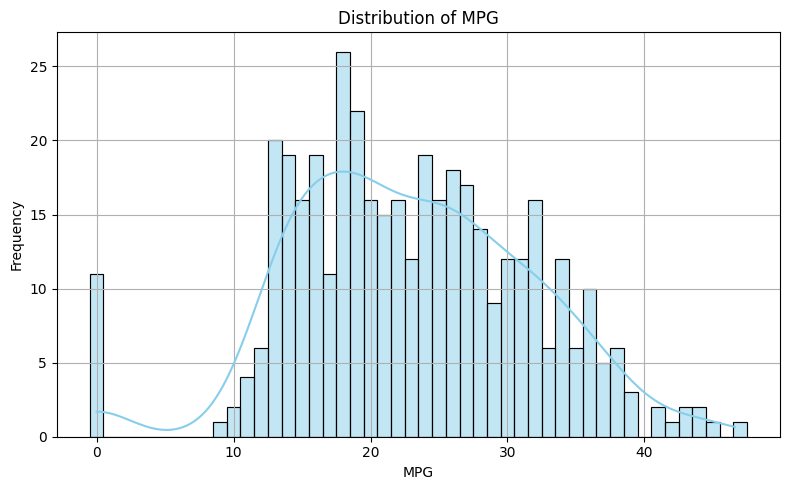

In [27]:
# Plot histogram and KDE of MPG
plt.figure(figsize=(8, 5))
sns.histplot(cars_df['MPG'].dropna(), kde=True, bins=30, color='skyblue')
plt.title('Distribution of MPG')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

If we observe the graph above, we can consider it in a way or another normally distributed. Therefore, we can impute the missing values using the mean.

In [28]:

# # Impute missing values in the MPG column using the mean
# mean_mpg = cars_df['MPG'].mean()
# cars_df['MPG'] = cars_df['MPG'].fillna(mean_mpg)

# # Confirm no missing values remain in the MPG column
# print("Missing values in MPG after imputation:", cars_df['MPG'].isnull().sum())
#####################################################################################
#  This code will raise an error because the 'MPG' column has some missing values.  #
#####################################################################################

To compute the mean we need numeric values. However the values in the dataframe are objects. Therefore, we need to change them to numerics so that we can compute them.

In [29]:
# To compute the mean, we must ensure the 'MPG' column is numeric.
# Convert it using pd.to_numeric, which turns invalid strings into NaN.
cars_df['MPG'] = pd.to_numeric(cars_df['MPG'], errors='coerce')
print('the data type of the MPG column after conversion:', cars_df['MPG'].dtype)

the data type of the MPG column after conversion: float64


Now let's see what is the mean of the MPG column

In [30]:
# Display the mean of the MPG column
mean_mpg = cars_df['MPG'].mean()
print(f"The mean of the MPG column is: {mean_mpg:.2f}")

The mean of the MPG column is: 22.93


We can use this mean to compute the missing values since the graph demonstarted a normal distribution

In [31]:
# we can impute the missing values using the mean.
cars_df['MPG'] = cars_df['MPG'].fillna(mean_mpg)
# Confirm no missing values remain in the MPG column
print("Missing values in MPG after imputation:", cars_df['MPG'].isnull().sum())

Missing values in MPG after imputation: 0


### **Car Dataset - Simple Imputer**

*SimpleImputer* is a `scikit-learn` class which is helpful in handling the missing data in the predictive model dataset. It replaces the `NaN` values with a specified placeholder.
It is implemented by the use of the `SimpleImputer()` method which takes the following arguments :

`missing_values` : The missing_values placeholder which has to be imputed. By default is NaN

`strategy` : The data which will replace the NaN values from the dataset. The strategy argument can take the values – ‘mean'(default), ‘median’, ‘most_frequent’ and ‘constant’.


Let's start by importing the `SimpleImputer` into our notebook

What we need to do are two essential steps:

1. fit the data (compute the mean / median / most freq)
2. transform the data (place the computed values in the NaN cells)

In [32]:
mean_mpg = cars_df['MPG'].mean()
median_mpg = cars_df['MPG'].median()
mode_mpg = cars_df['MPG'].mode()[0]  # mode() returns a Series; get the first value

print("Mean:", round(mean_mpg, 2))
print("Median:", round(median_mpg, 2))
print("Most Frequent (Mode):", mode_mpg)

Mean: 22.93
Median: 22.35
Most Frequent (Mode): 13.0


In [33]:

# Compute the mean
# as MPG is normally distributed, we can use the mean to fill missing values.
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(cars_df[['MPG']])
print("Mean value computed:", mean_imputer.statistics_[0])

# # Compute the median
# median_imputer = SimpleImputer(strategy='median')
# median_imputer.fit(cars_df[['MPG']])
# print("Median value computed:", median_imputer.statistics_[0])

# # Compute the most frequent
# mode_imputer = SimpleImputer(strategy='most_frequent')
# mode_imputer.fit(cars_df[['MPG']])
# print("Most frequent value computed:", mode_imputer.statistics_[0])

Mean value computed: 22.925615763546798


## **Outlier Detection** 


An Outlier is a data-item/object that deviates significantly from the rest of the (so-called normal)objects. They can be caused by measurement or execution errors. The analysis for outlier detection is referred to as outlier mining. There are many ways to detect the outliers, and the removal process is the data frame same as removing a data item from the panda’s data frame.



https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/





In [34]:
# Load the diabetes dataset from sklearn
# Load the dataset
diabetics = load_diabetes()

# Create the dataframe
column_name = diabetics.feature_names
df_diabetics = pd.DataFrame(diabetics.data)
df_diabetics.columns = column_name
print(df_diabetics.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


### Outliers Visualization

#### Visualizing Outliers Using Box Plot
It captures the summary of the data effectively and efficiently with only a simple box and whiskers. Boxplot summarizes sample data using 25th, 50th, and 75th percentiles. One can just get insights(quartiles, median, and outliers) into the dataset by just looking at its boxplot.

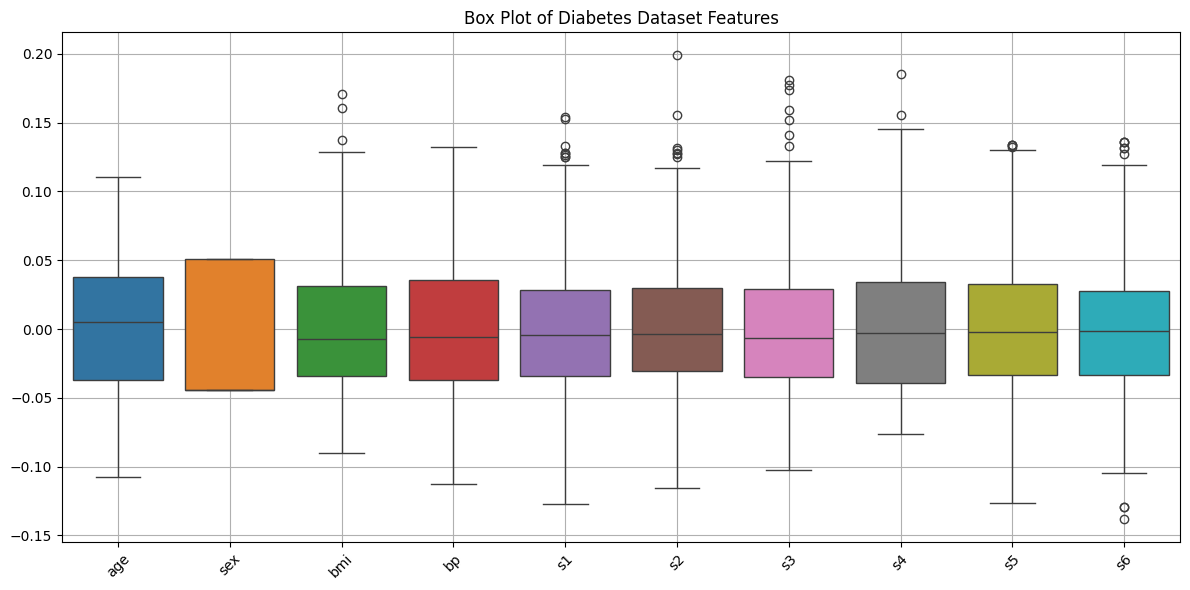

In [35]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the box plot for all features
sns.boxplot(data=df_diabetics)

# Add title and labels
plt.title("Box Plot of Diabetes Dataset Features")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Visualizing Outliers Using ScatterPlot.

It is used when you have paired numerical data and when your dependent variable has multiple values for each reading independent variable, or when trying to determine the relationship between the two variables. In the process of utilizing the scatter plot, one can also use it for outlier detection.

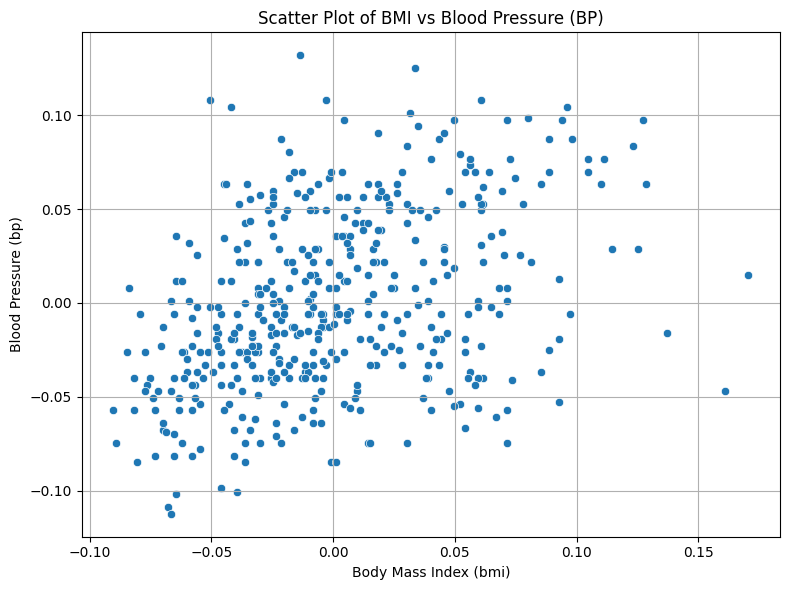

In [36]:
# Scatter plot: BMI vs BP
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='bp', data=df_diabetics)

# Add title and labels
plt.title("Scatter Plot of BMI vs Blood Pressure (BP)")
plt.xlabel("Body Mass Index (bmi)")
plt.ylabel("Blood Pressure (bp)")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


#### Z-Score:
Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.
<br>
Zscore = (data_point -mean) / std. deviation

For all columns :

if Z-score of 0 means the person’s value is exactly at the average.

if positive Z-score means the value is above the mean.

if  negative Z-score means the value is below the mean.

The further the Z-score from 0, the more "unusual" the value is (potential outlier if |Z| > 3).


In [37]:
# Calculate Z-scores for each feature
z_scores_df = df_diabetics.apply(zscore)
z_scores_df.columns = [col + '_zscore' for col in df_diabetics.columns]
# Display the first 5 rows of the Z-scores DataFrame
print(z_scores_df.head())

   age_zscore  sex_zscore  bmi_zscore  bp_zscore  s1_zscore  s2_zscore  \
0    0.800500    1.065488    1.297088   0.459841  -0.929746  -0.732065   
1   -0.039567   -0.938537   -1.082180  -0.553505  -0.177624  -0.402886   
2    1.793307    1.065488    0.934533  -0.119214  -0.958674  -0.718897   
3   -1.872441   -0.938537   -0.243771  -0.770650   0.256292   0.525397   
4    0.113172   -0.938537   -0.764944   0.459841   0.082726   0.327890   

   s3_zscore  s4_zscore  s5_zscore  s6_zscore  
0  -0.912451  -0.054499   0.418531  -0.370989  
1   1.564414  -0.830301  -1.436589  -1.938479  
2  -0.680245  -0.054499   0.060156  -0.545154  
3  -0.757647   0.721302   0.476983  -0.196823  
4   0.171178  -0.054499  -0.672502  -0.980568  


Now to define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

Rows where Z value is greater than 2

In [38]:
z_df = df_diabetics.apply(zscore)
z_df.columns = [col + '_zscore' for col in df_diabetics.columns]

# Boolean DataFrame: True where Z-score is an outlier (>|3|)
outlier_mask = np.abs(z_df) > 3

# Count total number of outlier values
total_outliers = outlier_mask.sum().sum()

# Count number of rows (people) with at least one outlier
rows_with_outliers = outlier_mask.any(axis=1).sum()

print(f" Total number of individual outlier values: {total_outliers}")
print(f" Number of rows (people) with at least one outlier: {rows_with_outliers}")

 Total number of individual outlier values: 15
 Number of rows (people) with at least one outlier: 12


#### IQR (Inter-Quartile Range)
Inter Quartile Range approach to finding the outliers is the most commonly used and most trusted approach used in the research field. <Br>
IQR = Quartile3 - Quartile1

In [39]:
# Loop through all features
for feature in df_diabetics.columns:
    col_data = df_diabetics[feature]

    # Step 1: Calculate Q1 and Q3
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)

    # Step 2: Calculate IQR
    IQR = Q3 - Q1

    # Step 3: Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 4: Print results
    print(f"--- {feature.upper()} ---")
    print(f"Q1: {Q1:.4f}")
    print(f"Q3: {Q3:.4f}")
    print(f"IQR: {IQR:.4f}")
    print(f"Lower Bound: {lower_bound:.4f}")
    print(f"Upper Bound: {upper_bound:.4f}")
    print()

--- AGE ---
Q1: -0.0373
Q3: 0.0381
IQR: 0.0754
Lower Bound: -0.1504
Upper Bound: 0.1511

--- SEX ---
Q1: -0.0446
Q3: 0.0507
IQR: 0.0953
Lower Bound: -0.1876
Upper Bound: 0.1937

--- BMI ---
Q1: -0.0342
Q3: 0.0312
IQR: 0.0655
Lower Bound: -0.1324
Upper Bound: 0.1295

--- BP ---
Q1: -0.0367
Q3: 0.0356
IQR: 0.0723
Lower Bound: -0.1451
Upper Bound: 0.1441

--- S1 ---
Q1: -0.0342
Q3: 0.0284
IQR: 0.0626
Lower Bound: -0.1282
Upper Bound: 0.1223

--- S2 ---
Q1: -0.0304
Q3: 0.0298
IQR: 0.0602
Lower Bound: -0.1207
Upper Bound: 0.1201

--- S3 ---
Q1: -0.0351
Q3: 0.0293
IQR: 0.0644
Lower Bound: -0.1318
Upper Bound: 0.1260

--- S4 ---
Q1: -0.0395
Q3: 0.0343
IQR: 0.0738
Lower Bound: -0.1502
Upper Bound: 0.1450

--- S5 ---
Q1: -0.0332
Q3: 0.0324
IQR: 0.0657
Lower Bound: -0.1318
Upper Bound: 0.1309

--- S6 ---
Q1: -0.0332
Q3: 0.0279
IQR: 0.0611
Lower Bound: -0.1248
Upper Bound: 0.1196



To define the outlier base value is defined above and below dataset’s normal range namely Upper and Lower bounds, define the upper and the lower bound (1.5*IQR value is considered) :<br>
upper = Q3 + 1.5 * IQR <br>
lower = Q1 - 1.5 * IQR <br> 

In [40]:
# Loop through all features to calculate bounds
for feature in df_diabetics.columns:
    col = df_diabetics[feature]
    
    # Step 1: Calculate Q1 and Q3
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    
    # Step 2: Compute IQR
    IQR = Q3 - Q1
    
    # Step 3: Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Step 4: Print the bounds
    print(f"--- {feature.upper()} ---")
    print(f"Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
    print(f"Lower Bound: {lower_bound:.4f}")
    print(f"Upper Bound: {upper_bound:.4f}")
    print()

--- AGE ---
Q1: -0.0373, Q3: 0.0381, IQR: 0.0754
Lower Bound: -0.1504
Upper Bound: 0.1511

--- SEX ---
Q1: -0.0446, Q3: 0.0507, IQR: 0.0953
Lower Bound: -0.1876
Upper Bound: 0.1937

--- BMI ---
Q1: -0.0342, Q3: 0.0312, IQR: 0.0655
Lower Bound: -0.1324
Upper Bound: 0.1295

--- BP ---
Q1: -0.0367, Q3: 0.0356, IQR: 0.0723
Lower Bound: -0.1451
Upper Bound: 0.1441

--- S1 ---
Q1: -0.0342, Q3: 0.0284, IQR: 0.0626
Lower Bound: -0.1282
Upper Bound: 0.1223

--- S2 ---
Q1: -0.0304, Q3: 0.0298, IQR: 0.0602
Lower Bound: -0.1207
Upper Bound: 0.1201

--- S3 ---
Q1: -0.0351, Q3: 0.0293, IQR: 0.0644
Lower Bound: -0.1318
Upper Bound: 0.1260

--- S4 ---
Q1: -0.0395, Q3: 0.0343, IQR: 0.0738
Lower Bound: -0.1502
Upper Bound: 0.1450

--- S5 ---
Q1: -0.0332, Q3: 0.0324, IQR: 0.0657
Lower Bound: -0.1318
Upper Bound: 0.1309

--- S6 ---
Q1: -0.0332, Q3: 0.0279, IQR: 0.0611
Lower Bound: -0.1248
Upper Bound: 0.1196



- Removing the outliers:
For removing the outlier, one must follow the same process of removing an entry from the dataset using its exact position in the dataset because in all the above methods of detecting the outliers end result is the list of all those data items that satisfy the outlier definition according to the method used.

In [41]:
# Create a copy to preserve the original
df_clean = df_diabetics.copy()

# Loop through all features and remove rows with outliers
for feature in df_diabetics.columns:
    Q1 = df_clean[feature].quantile(0.25)
    Q3 = df_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out rows that are outside bounds for this feature
    df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]

# Show results
print(f"Original dataset shape: {df_diabetics.shape}")
print(f"Dataset shape after removing outliers: {df_clean.shape}")

Original dataset shape: (442, 10)
Dataset shape after removing outliers: (407, 10)
